In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/data.csv')
data_hist = pd.read_csv('out/data_hist.csv')

In [3]:
data = data.drop(['id'], axis=1)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data_hist['timestamp'] = pd.to_datetime(data_hist['timestamp'])

data = data.set_index('timestamp')
data_hist = data_hist.set_index('timestamp')

### Combine

In [4]:
data = pd.concat([data, data_hist])
data.sort_index(inplace=True)

In [5]:
data.drop(columns=['outdoor_description'], inplace=True)

### EDA

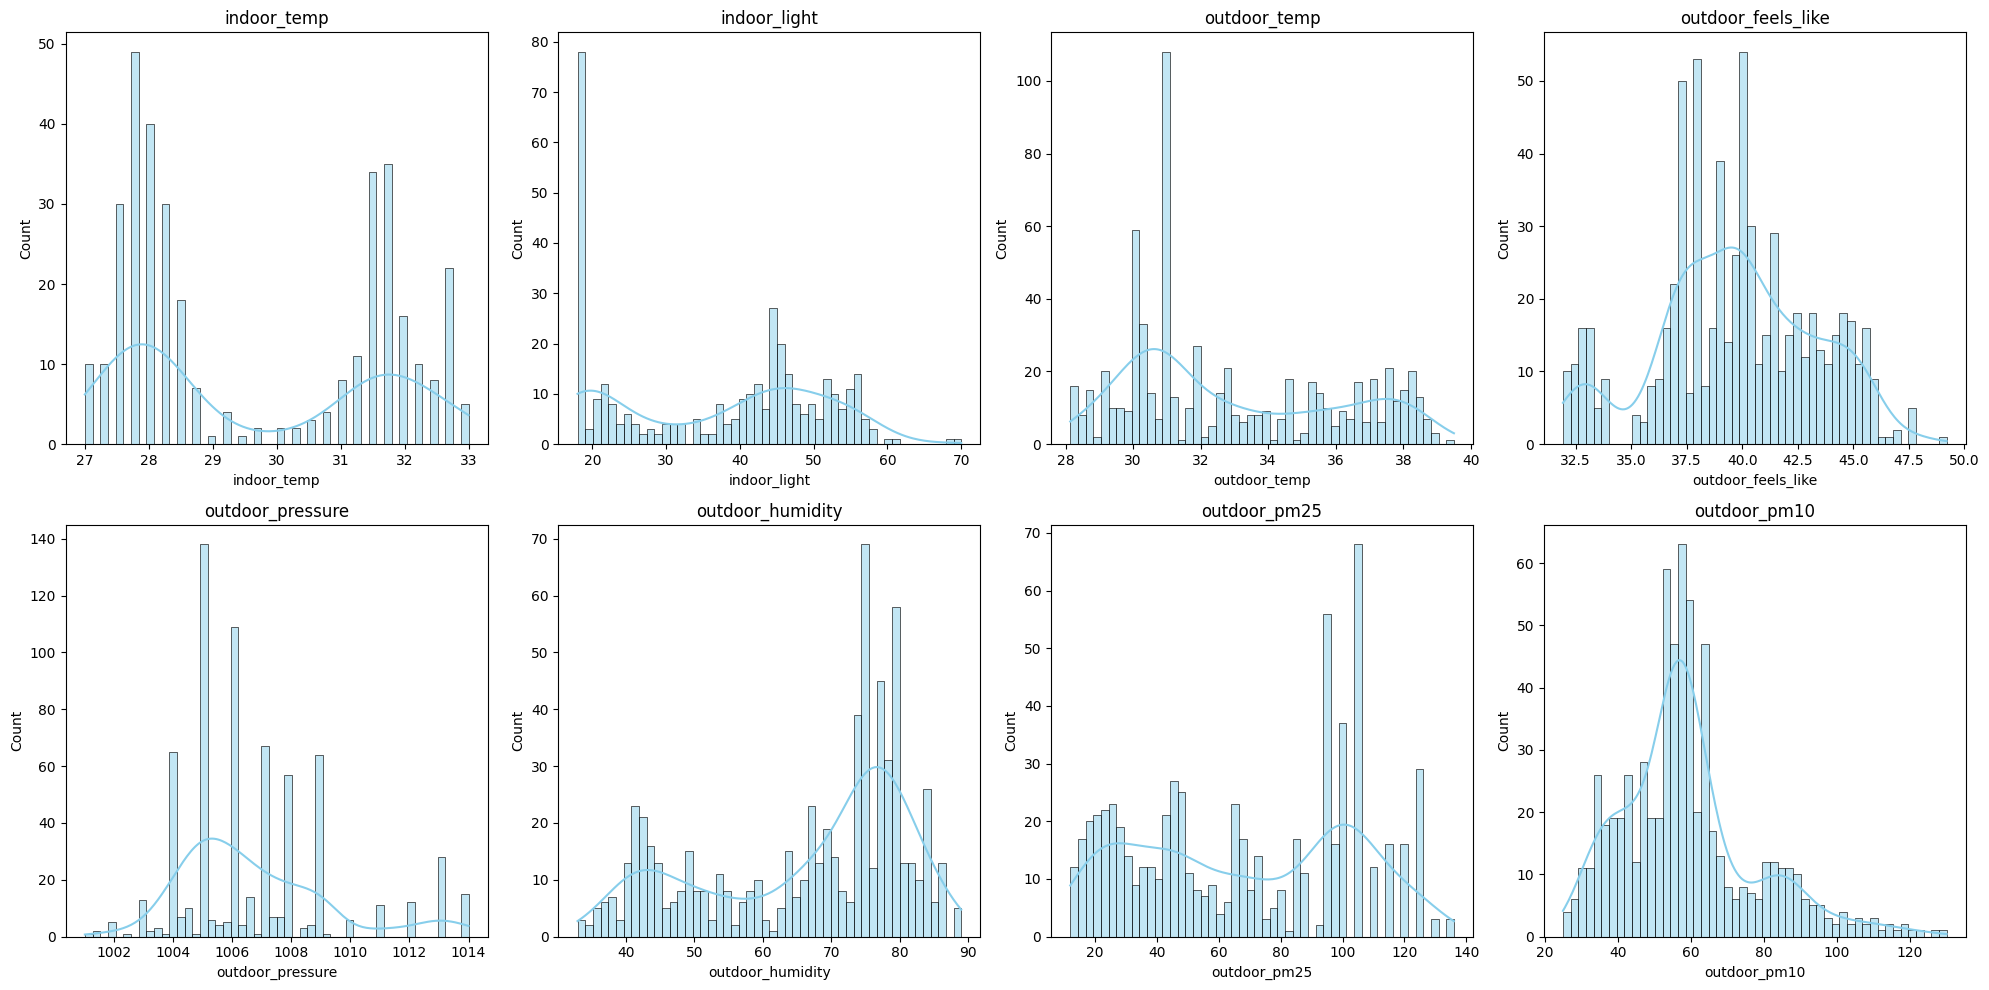

In [6]:
import seaborn as sns

# Plot distribution of data
to_plot = ['indoor_temp', 'indoor_light', 'outdoor_temp', 'outdoor_feels_like', 'outdoor_pressure', 'outdoor_humidity', 'outdoor_pm25', 'outdoor_pm10']

ax, fig = plt.subplots(2, 4, figsize=(20, 10))

for i, col in enumerate(to_plot):
    sns.histplot(data[col], ax=fig[i//4, i%4], kde=True, bins=50, color='skyblue')
    fig[i//4, i%4].set_title(col)

plt.tight_layout()
plt.show()

In [7]:
missing_values_data = data[data['indoor_temp'].isnull() | data['indoor_light'].isnull()]
non_missing_values_data = data.dropna(subset=['indoor_temp', 'indoor_light'])

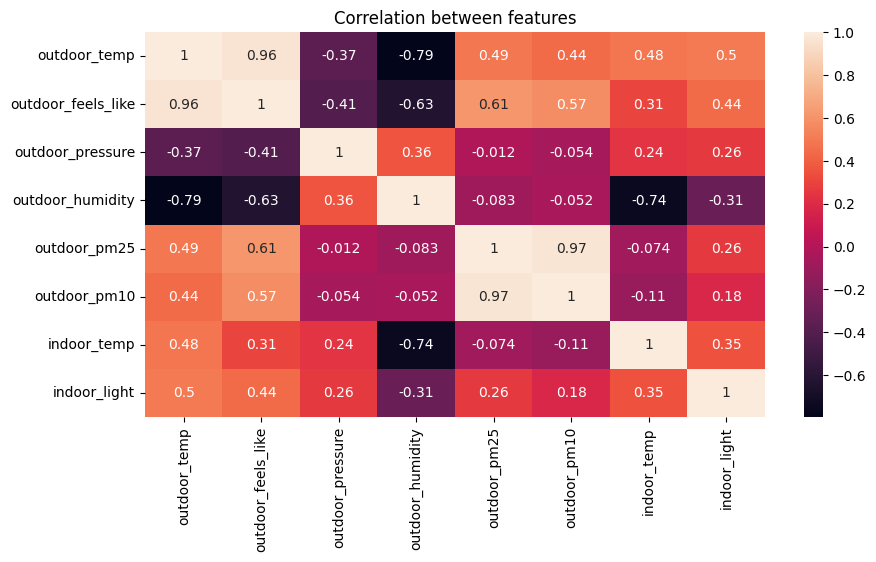

In [8]:
# heatmap of non_missing_values_data

plt.figure(figsize=(10, 5))
sns.heatmap(non_missing_values_data.drop(columns = 'outdoor_weather').corr(), annot=True)
plt.title('Correlation between features')
plt.show()

### Impute indoor data

#### Temp

In [9]:
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error

def plot_predict_vs_actual(test_set, prediction):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_set, y=test_set, mode='lines', name='Ideal Line', line=dict(color='red', dash='dash')))
    fig.add_trace(go.Scatter(x=test_set, y=prediction, mode='markers', name='Predictions', marker=dict(color='blue', opacity=0.5)))
    fig.update_layout(xaxis_title='Actual Values', yaxis_title='Predicted Values', title='Actual vs. Predicted Values', showlegend=True, legend=dict(x=0, y=1))
    fig.update_layout(xaxis=dict(showgrid=True), yaxis=dict(showgrid=True))
    fig.show()

def evaluate_regression(test_set, prediction):
    mse = mean_squared_error(test_set, prediction)
    rmse = mean_squared_error(test_set, prediction, squared=False)
    mae = mean_absolute_error(test_set, prediction)
    min_actual = min(test_set)
    max_actual = max(test_set)
    min_pred = min(prediction)
    max_pred = max(prediction)

    print('Mean Squared Error (MSE):', mse)
    print('Root Mean Squared Error (RMSE):', rmse)
    print('Mean Absolute Error (MAE):', mae)
    print('Range of Actual Values:', min_actual, '-', max_actual)
    print('Range of Predicted Values:', min_pred, '-', max_pred)


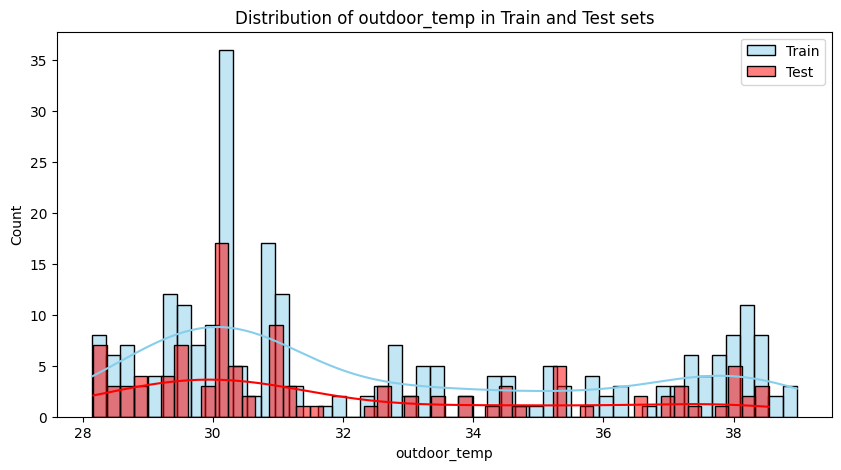

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from xgboost import XGBRegressor

X = non_missing_values_data.drop(columns=['indoor_temp', 'indoor_light', 'outdoor_weather'])
y = non_missing_values_data['indoor_temp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.figure(figsize=(10, 5))
sns.histplot(X_train['outdoor_temp'], color='skyblue', kde=True, label='Train', bins=50)
sns.histplot(X_test['outdoor_temp'], color='red', kde=True, label='Test', bins=50)
plt.title('Distribution of outdoor_temp in Train and Test sets')
plt.legend()
plt.show()

In [11]:
lr = LinearRegression()
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
xgboost = XGBRegressor(n_estimators=1000, max_depth=5, subsample=0.5, colsample_bytree=0.5, reg_alpha=0.1, reg_lambda=0.1, random_state=42)

lr.fit(X_train, y_train)    
elastic_net.fit(X_train, y_train)
xgboost.fit(X_train, y_train)

lr_pred = lr.predict(X_test)
elastic_net_pred = elastic_net.predict(X_test)
xgboost_pred = xgboost.predict(X_test)

In [12]:
print("--------Linear Regression--------")
evaluate_regression(y_test, lr_pred)
print("--------Elastic Net Regression--------")
evaluate_regression(y_test, elastic_net_pred)
print("--------XGBoost Regression--------")
evaluate_regression(y_test, xgboost_pred)

--------Linear Regression--------
Mean Squared Error (MSE): 0.6608169329742325
Root Mean Squared Error (RMSE): 0.8129064724642266
Mean Absolute Error (MAE): 0.6162669547028018
Range of Actual Values: 27.0 - 33.0
Range of Predicted Values: 27.344365040550883 - 32.7939224244771
--------Elastic Net Regression--------
Mean Squared Error (MSE): 0.6646796760845695
Root Mean Squared Error (RMSE): 0.8152788946640097
Mean Absolute Error (MAE): 0.627127849096193
Range of Actual Values: 27.0 - 33.0
Range of Predicted Values: 27.333999029486392 - 32.60513768012561
--------XGBoost Regression--------
Mean Squared Error (MSE): 0.2762279628701652
Root Mean Squared Error (RMSE): 0.5255739366351467
Mean Absolute Error (MAE): 0.2550343504739464
Range of Actual Values: 27.0 - 33.0
Range of Predicted Values: 27.22705 - 32.98418


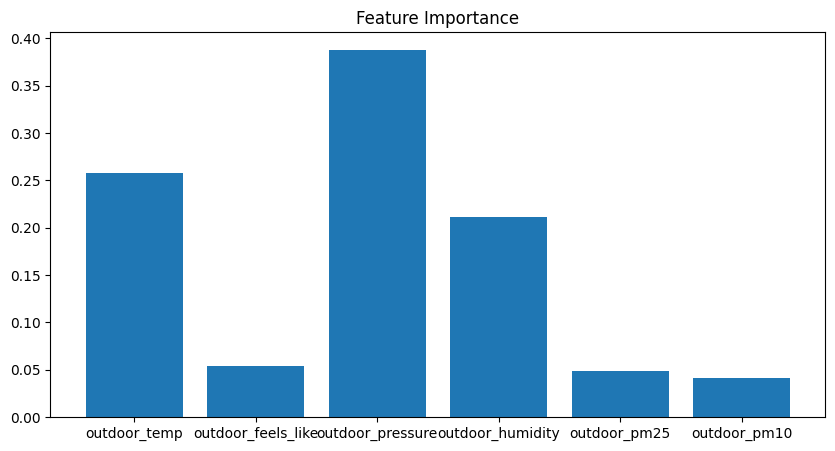

In [13]:
plt.figure(figsize=(10, 5))
plt.bar(X.columns, xgboost.feature_importances_)
plt.title('Feature Importance')
plt.show()

In [14]:
plot_predict_vs_actual(y_test, lr_pred)
plot_predict_vs_actual(y_test, elastic_net_pred)
plot_predict_vs_actual(y_test, xgboost_pred)

#### Light

In [15]:
X = non_missing_values_data.drop(columns=['indoor_temp', 'indoor_light', 'outdoor_weather'])
y = non_missing_values_data['indoor_light']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr_light = LinearRegression()
elastic_net_light = ElasticNet(alpha=0.1, l1_ratio=0.5)
xgboost_light = XGBRegressor(n_estimators=1000, max_depth=5, subsample=0.5, colsample_bytree=0.5, reg_alpha=0.1, reg_lambda=0.1, random_state=42)

lr_light.fit(X_train, y_train)    
elastic_net_light.fit(X_train, y_train)
xgboost_light.fit(X_train, y_train)

lr_pred = lr_light.predict(X_test)
elastic_net_pred = elastic_net_light.predict(X_test)
xgboost_pred = xgboost_light.predict(X_test)

In [16]:
plot_predict_vs_actual(y_test, lr_pred)
plot_predict_vs_actual(y_test, elastic_net_pred)
plot_predict_vs_actual(y_test, xgboost_pred)

#### Use XGBOOST for impute

In [17]:
missing_values_data

X_missing = missing_values_data.drop(columns=['indoor_temp', 'indoor_light', 'outdoor_weather'])

predict_temp = xgboost.predict(X_missing)
predict_light = xgboost_light.predict(X_missing)

missing_values_data['indoor_temp'] = predict_temp
missing_values_data['indoor_light'] = predict_light

missing_values_data

C:\Users\sirin\AppData\Local\Temp\ipykernel_2916\2755105794.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sirin\AppData\Local\Temp\ipykernel_2916\2755105794.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,outdoor_temp,outdoor_feels_like,outdoor_pressure,outdoor_humidity,outdoor_weather,outdoor_pm25,outdoor_pm10,indoor_temp,indoor_light
timestamp,,,,,,,,,
2024-04-24 00:00:00,30.7,38.3,1006.0,74.75,Partially cloudy,16.000000,34.000000,28.390335,22.470850
2024-04-24 01:00:00,30.3,40.0,1005.3,83.88,Partially cloudy,16.739130,35.260870,28.833687,33.111301
2024-04-24 02:00:00,30.0,37.4,1005.0,79.19,Partially cloudy,17.478261,36.521739,27.750225,42.613968
2024-04-24 03:00:00,30.2,37.5,1005.0,76.90,Partially cloudy,18.217391,37.782609,29.299782,13.389190
2024-04-24 04:00:00,30.3,39.2,1004.8,81.57,Partially cloudy,18.956522,39.043478,28.839397,28.459419
...,...,...,...,...,...,...,...,...,...
2024-05-06 19:00:00,32.9,38.8,1007.0,58.34,Partially cloudy,48.608696,85.956522,28.382135,29.520912
2024-05-06 20:00:00,32.6,39.9,1007.0,64.24,"Rain, Partially cloudy",48.956522,87.217391,28.456205,31.247889
2024-05-06 21:00:00,32.6,39.6,1007.0,63.24,Partially cloudy,49.304348,88.478261,28.431677,29.528757


### Concat

In [18]:
data = pd.concat([missing_values_data, non_missing_values_data])
data.sort_index(inplace=True)
data.isnull().sum()

outdoor_temp          0
outdoor_feels_like    0
outdoor_pressure      0
outdoor_humidity      0
outdoor_weather       0
outdoor_pm25          0
outdoor_pm10          0
indoor_temp           0
indoor_light          0
dtype: int64

In [19]:
data

,outdoor_temp,outdoor_feels_like,outdoor_pressure,outdoor_humidity,outdoor_weather,outdoor_pm25,outdoor_pm10,indoor_temp,indoor_light
timestamp,,,,,,,,,
2024-04-19 02:46:07,29.83,33.31,1005.0,64.0,Clouds,65.0,33.0,27.75,42.0
2024-04-19 02:47:04,29.80,33.25,1005.0,64.0,Clouds,65.0,33.0,27.75,42.0
2024-04-19 02:55:01,29.24,32.13,1005.0,64.0,Clouds,65.0,34.0,28.00,42.0
2024-04-19 03:00:02,29.24,32.13,1005.0,64.0,Clouds,65.0,34.0,27.75,42.0
2024-04-19 03:05:02,29.24,32.13,1005.0,64.0,Clouds,65.0,34.0,27.50,42.0
...,...,...,...,...,...,...,...,...,...
2024-05-07 14:40:47,28.88,35.50,1011.0,85.0,Rain,59.0,31.0,31.25,48.0
2024-05-07 14:45:45,28.88,35.50,1011.0,85.0,Rain,59.0,31.0,31.25,47.0
2024-05-07 14:50:45,29.18,35.25,1011.0,80.0,Rain,63.0,32.0,31.25,47.0


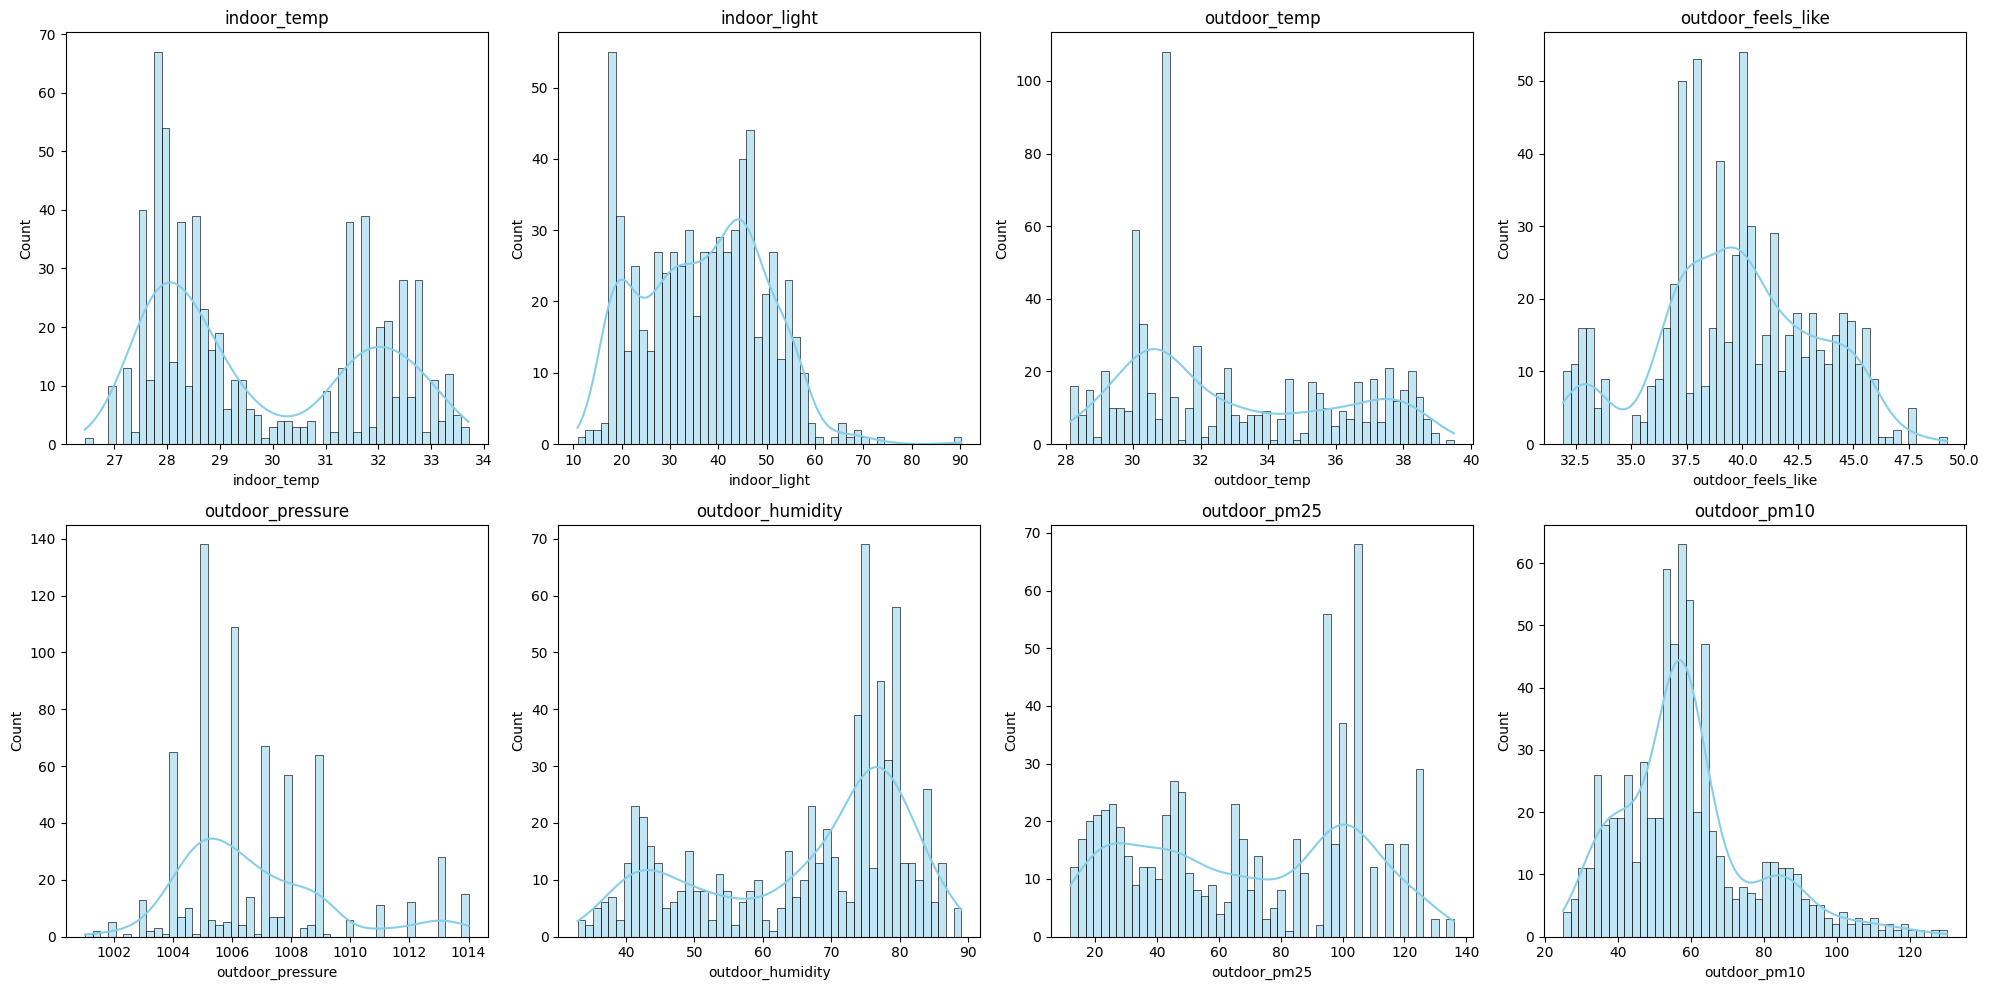

In [20]:
import seaborn as sns

to_plot = ['indoor_temp', 'indoor_light', 'outdoor_temp', 'outdoor_feels_like', 'outdoor_pressure', 'outdoor_humidity', 'outdoor_pm25', 'outdoor_pm10']

ax, fig = plt.subplots(2, 4, figsize=(20, 10))

for i, col in enumerate(to_plot):
    sns.histplot(data[col], ax=fig[i//4, i%4], kde=True, bins=50, color='skyblue')
    fig[i//4, i%4].set_title(col)

plt.tight_layout()
plt.show()

In [21]:
data.to_csv('out/data_cleaned.csv')